<a href="https://colab.research.google.com/github/lee-53/ECE-4380-F25/blob/main/Copy_of_Clear_PTandTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch and Intro to Training

## Start by importing necessary packages
We will begin by importing necessary libraries for this notebook. Run the cell below to do so.

In [ ]:
!pip install thop
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import thop
import matplotlib.pyplot as plt
from tqdm import tqdm
import time


## Checking the torch version and CUDA access
Let's start off by checking the current torch version, and whether we have CUDA availablity.

In [ ]:
print("toch is using version:", torch.__version__, "with CUDA=", torch.cuda.is_available())

toch is using version: 2.8.0+cu126 with CUDA= True


By default, we should see CUDA= False, meaning that the Colab instances does not have access to a GPU. To remedy this, click the drop-down arrow next to resources, and select "Change Runtime Type", then select "T4 GPU"
Re-run the import cell, and the CUDA version / check above. It should now CUDA= True

We won't be using the GPU just yet, but this prepares the instance for when we do.

## A Brief Introduction to PyTorch

PyTorch, or torch, is a machine learning framework developed my Facebook AI Research, which is competes with TensorFlow, JAX, and Caffe.

Roughly speaking, these frameworks can be split into dynamic and static defintion frameworks.

**Static Network Definition:** The architecture and computation flow are defined simultaneously. The order and manner in which data flows through the layers are fixed upon definition. These frameworks also tend to declare parameter shapes implicitly via the compute graph. This is typical of TensorFlow and JAX.

**Dynamic Network Definition:** The architecture (layers/modules) is defined independently of the computation flow, often during the object's initialization. This allows for dynamic computation graphs where the flow of data can change during runtime based on conditions. Since the network exists independent of the compute graph, the parameter shapes must be declared explitly. PyTorch follows this approach.

All of the ML frameworks support automatic differentiation, which is necessary to train a model (i.e. perform back propogation).

Let's consider a typical pytorch module. These will inherit from the torch.nn.Module class, which provides many built in functions such as a wrapper for `__call__`, operations to move the module between devices (e.g. `cuda()`, `cpu()`), data-type conversion (e.g. `half()`, `float()`), and parameter and child management (e.g. `state_dict()`, `parameters()`).

In [ ]:
# inherit from torch.nn.Module
class MyModule(nn.Module):
  # constructor called upon creation
  def __init__(self):
    # the module has to initialize the parent first, which is what sets up the wrapper behavior
    super().__init__()

    # we can add sub-modules and parameters by assigning them to self
    self.my_param = nn.Parameter(torch.zeros(4,8)) # this is how you define a raw parameter of shape 4x5
    self.my_sub_module = nn.Linear(8,12)       # this is how you define a linear layer (tensorflow calls them Dense) of shape 8x12

    # we can also add lists of modules, for example, the sequential layer
    self.net = nn.Sequential(  # this layer type takes in a collection of modules rather than a list
        nn.Linear(4,4),
        nn.Linear(4,8),
        nn.Linear(8,12)
    )

    # the above when calling self.net(x), will execute each module in the order they appear in a list
    # it would be equivelent to x = self.net[2](self.net[1](self.net[0](x)))

    # you can also create a list that doesn't execute
    self.net_list = nn.ModuleList([
        nn.Linear(7,7),
        nn.Linear(7,9),
        nn.Linear(9,14)
    ])

    # sometimes you will also see constant variables added to the module post init
    foo = torch.Tensor([4])
    self.register_buffer('foo', foo) # buffers allow .to(device, type) to apply

  # let's define a forward function, which gets executed when calling the module, and defines the forward compute graph
  def forward(self, x):

    # if x is of shape Bx4
    h1 =  x @ self.my_param # tensor-tensor multiplication uses the @ symbol
    # then h1 is now shape Bx8, because my_param is 4x8... 2x4 * 4x8 = 2x8

    h1 = self.my_sub_module(h1) # you execute a sub-module by calling it
    # now, h1 is of shape Bx12, because my_sub_module was a 8x12 matrix

    h2 = self.net(x)
    # similarly, h2 is of shape Bx12, because that's the output of the sequence
    # Bx4 -(4x4)-> Bx4 -(4x8)-> Bx8 -(8x12)-> Bx12

    # since h1 and h2 are the same shape, they can be added together element-wise
    return h1 + h2


Then we can instantiate the module and perform a forward pass by calling it.

In [ ]:
# create the module
module = MyModule()

# we can print the module to get a high-level summary of it
print("=== printing the module ===")
print(module)
print()
# notice that the sub-module name is in parenthesis, and so are the list indicies

# let's view the shape of one of the weight tensors
print("my_sub_module weight tensor shape=", module.my_sub_module.weight.shape)
# the above works because nn.Linear has a member called .weight and .bias
# to view the shape of my_param, you would use module.my_param
# and to view the shape of the 2nd elment in net_list, you would use module.net_list[1].weight

# we can iterate through all of the parameters via the state dict
print()
print("=== Listing parameters from the state_dict ===")
for key,value in module.state_dict().items():
  print(f"{key}: {value.shape}")


=== printing the module ===
MyModule(
  (my_sub_module): Linear(in_features=8, out_features=12, bias=True)
  (net): Sequential(
    (0): Linear(in_features=4, out_features=4, bias=True)
    (1): Linear(in_features=4, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=12, bias=True)
  )
  (net_list): ModuleList(
    (0): Linear(in_features=7, out_features=7, bias=True)
    (1): Linear(in_features=7, out_features=9, bias=True)
    (2): Linear(in_features=9, out_features=14, bias=True)
  )
)

my_sub_module weight tensor shape= torch.Size([12, 8])

=== Listing parameters from the state_dict ===
my_param: torch.Size([4, 8])
foo: torch.Size([1])
my_sub_module.weight: torch.Size([12, 8])
my_sub_module.bias: torch.Size([12])
net.0.weight: torch.Size([4, 4])
net.0.bias: torch.Size([4])
net.1.weight: torch.Size([8, 4])
net.1.bias: torch.Size([8])
net.2.weight: torch.Size([12, 8])
net.2.bias: torch.Size([12])
net_list.0.weight: torch.Size([7, 7])
net_list.0.bias: torch.Size([7

In [ ]:
# we can perform a forward pass by first creating a tensor to send through
x = torch.zeros(2,4)
# then we call the module (this invokes MyModule.forward() )
y = module(x)

# then we can print the result and shape
print(y, y.shape)

tensor([[-0.2144,  0.1095, -0.7052, -0.7054, -0.1362,  0.3881,  0.4487,  0.2244,
          0.8016, -0.4009, -0.4681, -0.3908],
        [-0.2144,  0.1095, -0.7052, -0.7054, -0.1362,  0.3881,  0.4487,  0.2244,
          0.8016, -0.4009, -0.4681, -0.3908]], grad_fn=<AddBackward0>) torch.Size([2, 12])


A few things to notice.


1.   `x` was created with the shape 2x4, and in the forward pass, it gets manipulated into a 2x12 tensor. This the last dimension is explicit, while the first is called the batch dimmension, and only exists on data (a.k.a. activations). The output shape can be seen in the print statement from y.shape
2.   You can view the shape of a tensor by using `.shape`, this is a very helpful trick for debugging tensor shape errors
3.   In the output, there's a `grad_fn` component, this is the hook created by the forward trace to be used in back-propogation via automatic differentiation. The function name is `AddBackward`, because the last operation performed was `h1+h2`.

We might not always want to trace the compute graph though, such as during inference. In such cases, we can use the `torch.no_grad()` context manager.


In [ ]:
# we can perform a forward pass by first creating a tensor to send through
x = torch.zeros(2,4)
# then we call the module (this invokes MyModule.forward() )
with torch.no_grad():
  y = module(x)

# then we can print the result and shape
print(y, y.shape)
# notice how the grad_fn is no longer part of the output tensor, that's because not_grad() disables the graph generation

tensor([[-0.2144,  0.1095, -0.7052, -0.7054, -0.1362,  0.3881,  0.4487,  0.2244,
          0.8016, -0.4009, -0.4681, -0.3908],
        [-0.2144,  0.1095, -0.7052, -0.7054, -0.1362,  0.3881,  0.4487,  0.2244,
          0.8016, -0.4009, -0.4681, -0.3908]]) torch.Size([2, 12])


Aside from passing a tensor through a model with the `no_grad()` context, we can also detach a tensor from the compute graph by calling `.detach()`. This will effectively make a copy of the original tensor, which allows it to be converted to numpy and visualized with matplotlib.

**Note:** Tensors with a `grad_fn` property cannot be plotted and must first be detached.

## Multi-Layer-Perceptron (MLP) Prediction of MNIST

With some basics out of the way, let's create a MLP for training MNIST.
We can start by defining a simple torch model.

In [ ]:
# Define the MLP model
class MLP(nn.Module):
    # define the constructor for the network
    def __init__(self):
        super().__init__()
        # the input projection layer - projects into d=128
        self.fc1 = nn.Linear(28*28, 128)
        # the first hidden layer - compresses into d=64
        self.fc2 = nn.Linear(128, 64)
        # the final output layer - splits into 10 classes (digits 0-9)
        self.fc3 = nn.Linear(64, 10)

    # define the forward pass compute graph
    def forward(self, x):
        # x is of shape BxHxW

        # we first need to unroll the 2D image using view
        # we set the first dim to be -1 meanining "everything else", the reason being that x is of shape BxHxW, where B is the batch dim
        # we want to maintain different tensors for each training sample in the batch, which means the output should be of shape BxF where F is the feature dim
        x = x.view(-1, 28*28)
        # x is of shape Bx784

        # project-in and apply a non-linearity (ReLU activation function)
        x = torch.relu(self.fc1(x))
        # x is of shape Bx128

        # middle-layer and apply a non-linearity (ReLU activation function)
        x = torch.relu(self.fc2(x))
        # x is of shape Bx64

        # project out into the 10 classes
        x = self.fc3(x)
        # x is of shape Bx10
        return x

Before we can begin training, we have to do a little boiler-plate to load the dataset. From the previous part, you saw how a hosted dataset can be loaded with TensorFlow. With pytorch it's a little more complicated, as we need to manually condition the input data.

In [ ]:
# define a transformation for the input images. This uses torchvision.transforms, and .Compose will act similarly to nn.Sequential
transform = transforms.Compose([
    transforms.ToTensor(), # first convert to a torch tensor
    transforms.Normalize((0.1307,), (0.3081,)) # then normalize the input
])

# let's download the train and test datasets, applying the above transform - this will get saved locally into ./data, which is in the Colab instance
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

# we need to set the mini-batch (commonly referred to as "batch"), for now we can use 64
batch_size = 64

# then we need to create a dataloader for the train dataset, and we will also create one for the test dataset to evaluate performance
# additionally, we will set the batch size in the dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# the torch dataloaders allow us to access the __getitem__ method, which returns a tuple of (data, label)
# additionally, the dataloader will pre-colate the training samples into the given batch_size


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.8MB/s]


Inspect the first element of the test_loader, and verify both the tensor shapes and data types. You can check the data-type with `.dtype`

**Question 1**

In [ ]:
# Get the first item
first_item = next(iter(test_loader))

# print out the element shapes, dtype, and identify which is the training sample and which is the training label - MNIST is a supervised learning task

# shape of sample
print("sample shape:", first_item[0].shape)
# dtype of sample
print("sample dtype:", first_item[0].dtype)

# shape of labels
print("label shape:", first_item[1].shape)
# dtype of labels
print("label dtype:", first_item[1].dtype)

sample shape: torch.Size([64, 1, 28, 28])
sample dtype: torch.float32
label shape: torch.Size([64])
label dtype: torch.int64


Now that we have the dataset loaded, we can instantiate the MLP model, the loss (or criteron function), and the optimizer for training.

In [ ]:
# create the model
model = MLP()

# we can print the model as well, but notice how the activation functions are missing. This is because they were called in the forward pass and not declared in the constructor
print(model)

# we can also count the model parameters
param_count = sum([p.numel() for p in model.parameters()])
print(f"Model has {param_count:,} trainable parameters")

# for a critereon (loss) funciton, we will use Cross-Entropy Loss. This is the most common critereon used for multi-class prediction, and is also used by tokenized transformer models
# it takes in an un-normalized probability distribution (i.e. without softmax) over N classes (in our case, 10 classes with MNIST). This distribution is then compared to an integer label
# which is < N. For MNIST, the prediction might be [-0.0056, -0.2044,  1.1726,  0.0859,  1.8443, -0.9627,  0.9785, -1.0752, 1.1376,  1.8220], with the label 3.
# Cross-entropy can be thought of as finding the difference between what the predicted distribution and the one-hot distribution

criterion = nn.CrossEntropyLoss()

# then we can intantiate the optimizer. We will use Stochastic Gradient Descent (SGD), and can set the learning rate to 0.1 with a momentum factor of 0.5
# the first input to the optimizer is the list of model parameters, which is obtained by calling .parameters() on the model object
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)
Model has 109,386 trainable parameters


Finally, we can define a training, and test loop

In [ ]:
# create an array to log the loss and accuracy
train_losses = []
train_steps = []
test_steps = []
test_losses = []
test_accuracy = []
current_step = 0  # Start with global step 0
current_epoch = 0 # Start with epoch 0

In [ ]:
# declare the train function
def cpu_train(epoch, train_losses, steps, current_step):

    # set the model in training mode - this doesn't do anything for us right now, but it is good practiced and needed with other layers such as batch norm and dropout
    model.train()

    # Create tqdm progress bar to help keep track of the training progress
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))

    # loop over the dataset. Recall what comes out of the data loader, and then by wrapping that with enumerate() we get an index into the iterator list which we will call batch_idx
    for batch_idx, (data, target) in pbar:

        # during training, the first step is to zero all of the gradients through the optimizer
        # this resets the state so that we can begin back propogation with the updated parameters
        optimizer.zero_grad()

        # then we apply a forward pass, which includes evaluating the loss (critereon)
        output = model(data)
        loss = criterion(output, target)

        # given that we want to minimize the loss, we call .backward() on the result, which invokes the grad_fn property
        loss.backward()

        # the backward step will automatically differentiate the model and apply a gradient property to each of the parameters in the network
        # so then all we have to do is call optimizer.step() to apply the gradients to the current parameters
        optimizer.step()

        # increment the step count
        current_step += 1

        # we should add some output to the progress bar so that we know which epoch we are training, and what the current loss is
        if batch_idx % 100 == 0:

            # append the last loss value
            train_losses.append(loss.item())
            steps.append(current_step)

            desc = (f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                    f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            pbar.set_description(desc)

    return current_step

# declare a test function, this will help us evaluate the model progress on a dataset which is different from the training dataset
# doing so prevents cross-contamination and misleading results due to overfitting
def cpu_test(test_losses, test_accuracy, steps, current_step):

    # put the model into eval mode, this again does not currently do anything for us, but it is needed with other layers like batch_norm and dropout
    model.eval()
    test_loss = 0
    correct = 0

    # Create tqdm progress bar
    pbar = tqdm(test_loader, total=len(test_loader), desc="Testing...")

    # since we are not training the model, and do not need back-propogation, we can use a no_grad() context
    with torch.no_grad():
        # iterate over the test set
        for data, target in pbar:
            # like with training, run a forward pass through the model and evaluate the critereon
            output = model(data)
            test_loss += criterion(output, target).item() # we are using .item() to get the loss value rather than the tensor itself

            # we can also check the accuracy by sampling the output - we can use greedy sampling which is argmax (maximum probability)
            # in general, you would want to normalize the logits first (the un-normalized output of the model), which is done via .softmax()
            # however, argmax is taking the maximum value, which will be the same index for the normalized and un-normalized distributions
            # so we can skip a step and take argmax directly
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)

    # append the final test loss
    test_losses.append(test_loss)
    test_accuracy.append(correct/len(test_loader.dataset))
    steps.append(current_step)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}'
          f' ({100. * correct / len(test_loader.dataset):.0f}%)\n')


In [ ]:
# train for 10 epochs
for epoch in range(0, 10):
    current_step = cpu_train(current_epoch, train_losses, train_steps, current_step)
    cpu_test(test_losses, test_accuracy, test_steps, current_step)
    current_epoch += 1

Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.237482: 100%|██████████| 938/938 [00:17<00:00, 53.91it/s]
Testing...: 100%|██████████| 157/157 [00:01<00:00, 82.48it/s]



Test set: Average loss: 0.2797, Accuracy: 9182/10000 (92%)



Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.127036: 100%|██████████| 938/938 [00:12<00:00, 72.59it/s]
Testing...: 100%|██████████| 157/157 [00:01<00:00, 83.80it/s]



Test set: Average loss: 0.2118, Accuracy: 9359/10000 (94%)



Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.110276: 100%|██████████| 938/938 [00:12<00:00, 72.38it/s]
Testing...: 100%|██████████| 157/157 [00:01<00:00, 81.61it/s]



Test set: Average loss: 0.1760, Accuracy: 9466/10000 (95%)



Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.133975: 100%|██████████| 938/938 [00:13<00:00, 69.06it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 68.09it/s]



Test set: Average loss: 0.1436, Accuracy: 9572/10000 (96%)



Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.133922: 100%|██████████| 938/938 [00:13<00:00, 71.73it/s]
Testing...: 100%|██████████| 157/157 [00:01<00:00, 81.35it/s]



Test set: Average loss: 0.1232, Accuracy: 9626/10000 (96%)



Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.200447: 100%|██████████| 938/938 [00:12<00:00, 72.26it/s]
Testing...: 100%|██████████| 157/157 [00:01<00:00, 82.80it/s]



Test set: Average loss: 0.1133, Accuracy: 9657/10000 (97%)



Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.061175: 100%|██████████| 938/938 [00:13<00:00, 69.89it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 75.55it/s]



Test set: Average loss: 0.1023, Accuracy: 9681/10000 (97%)



Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.161143: 100%|██████████| 938/938 [00:15<00:00, 61.08it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 62.14it/s]



Test set: Average loss: 0.0962, Accuracy: 9698/10000 (97%)



Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.051372: 100%|██████████| 938/938 [00:14<00:00, 63.27it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 73.98it/s]



Test set: Average loss: 0.0898, Accuracy: 9721/10000 (97%)



Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.064448: 100%|██████████| 938/938 [00:13<00:00, 70.03it/s]
Testing...: 100%|██████████| 157/157 [00:01<00:00, 85.39it/s]


Test set: Average loss: 0.0878, Accuracy: 9729/10000 (97%)



Visualize the loss for training and validation using matplotlib. They should be plotted on the same graph, labeled, and use a log-scale on the y-axis.

**Question 2**

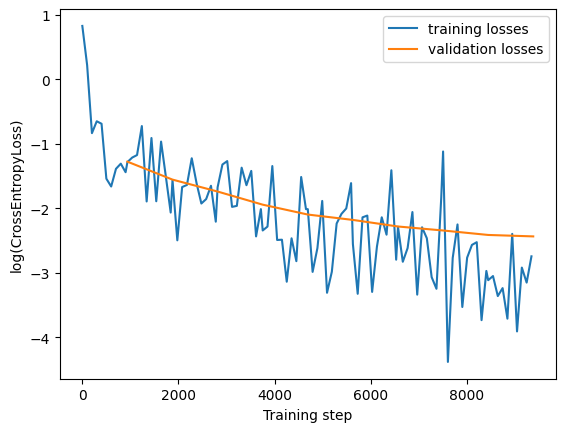

In [ ]:
# visualize the losses for the first 10 epochs
plt.plot(train_steps, np.log(train_losses), label="training losses")
plt.plot(test_steps, np.log(test_losses), label="validation losses")
plt.xlabel("Training step")
plt.ylabel("log(CrossEntropyLoss)")
plt.legend()

plt.show()

The model may be able to train for a bit longer. Modify the previous training code to also report the time per epoch and the time for 10 epochs with testing. You can use `time.time()` to get the current time in seconds.
Then run the model for another 10 epochs, printing out the execution time at the end, and replot the loss functions with the extra 10 epochs below.

**Question 3**

Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.161994: 100%|██████████| 938/938 [00:13<00:00, 72.07it/s]



Epoch 0 time (seconds): 13.018791198730469 



Testing...: 100%|██████████| 157/157 [00:01<00:00, 82.08it/s]



Test set: Average loss: 0.2732, Accuracy: 9199/10000 (92%)



Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.186225: 100%|██████████| 938/938 [00:12<00:00, 72.78it/s]



Epoch 1 time (seconds): 12.891470909118652 



Testing...: 100%|██████████| 157/157 [00:01<00:00, 82.64it/s]



Test set: Average loss: 0.2089, Accuracy: 9379/10000 (94%)



Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.122715: 100%|██████████| 938/938 [00:13<00:00, 70.43it/s]



Epoch 2 time (seconds): 13.320712566375732 



Testing...: 100%|██████████| 157/157 [00:02<00:00, 75.15it/s]



Test set: Average loss: 0.1690, Accuracy: 9510/10000 (95%)



Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.144852: 100%|██████████| 938/938 [00:13<00:00, 71.07it/s]



Epoch 3 time (seconds): 13.201497793197632 



Testing...: 100%|██████████| 157/157 [00:02<00:00, 72.03it/s]



Test set: Average loss: 0.1470, Accuracy: 9563/10000 (96%)



Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.170265: 100%|██████████| 938/938 [00:12<00:00, 73.79it/s]



Epoch 4 time (seconds): 12.715159893035889 



Testing...: 100%|██████████| 157/157 [00:01<00:00, 84.97it/s]



Test set: Average loss: 0.1254, Accuracy: 9637/10000 (96%)



Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.048087: 100%|██████████| 938/938 [00:12<00:00, 74.14it/s]



Epoch 5 time (seconds): 12.653436660766602 



Testing...: 100%|██████████| 157/157 [00:01<00:00, 82.96it/s]



Test set: Average loss: 0.1159, Accuracy: 9640/10000 (96%)



Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.133592: 100%|██████████| 938/938 [00:12<00:00, 74.33it/s]



Epoch 6 time (seconds): 12.622749090194702 



Testing...: 100%|██████████| 157/157 [00:01<00:00, 85.39it/s]



Test set: Average loss: 0.1014, Accuracy: 9701/10000 (97%)



Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.096010: 100%|██████████| 938/938 [00:12<00:00, 72.78it/s]



Epoch 7 time (seconds): 12.893201112747192 



Testing...: 100%|██████████| 157/157 [00:02<00:00, 66.23it/s]



Test set: Average loss: 0.0950, Accuracy: 9701/10000 (97%)



Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.086695: 100%|██████████| 938/938 [00:13<00:00, 67.22it/s]



Epoch 8 time (seconds): 13.95726227760315 



Testing...: 100%|██████████| 157/157 [00:02<00:00, 72.33it/s]



Test set: Average loss: 0.0883, Accuracy: 9724/10000 (97%)



Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.020728: 100%|██████████| 938/938 [00:13<00:00, 67.12it/s]



Epoch 9 time (seconds): 13.97778582572937 



Testing...: 100%|██████████| 157/157 [00:02<00:00, 77.39it/s]



Test set: Average loss: 0.0852, Accuracy: 9729/10000 (97%)


Time for 10 epochs with testing (seconds): 151.51305413246155 



Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.122659: 100%|██████████| 938/938 [00:13<00:00, 68.66it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 61.43it/s]



Test set: Average loss: 0.0852, Accuracy: 9731/10000 (97%)



Train Epoch: 11 [57600/60000 (96%)]	Loss: 0.126670: 100%|██████████| 938/938 [00:13<00:00, 68.49it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 76.66it/s]



Test set: Average loss: 0.0789, Accuracy: 9758/10000 (98%)



Train Epoch: 12 [57600/60000 (96%)]	Loss: 0.009134: 100%|██████████| 938/938 [00:14<00:00, 65.94it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 74.19it/s]



Test set: Average loss: 0.0753, Accuracy: 9764/10000 (98%)



Train Epoch: 13 [57600/60000 (96%)]	Loss: 0.020248: 100%|██████████| 938/938 [00:14<00:00, 64.96it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 56.32it/s]



Test set: Average loss: 0.0770, Accuracy: 9753/10000 (98%)



Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.010334: 100%|██████████| 938/938 [00:14<00:00, 66.27it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 76.91it/s]



Test set: Average loss: 0.0761, Accuracy: 9766/10000 (98%)



Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.064503: 100%|██████████| 938/938 [00:14<00:00, 66.85it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 78.36it/s]



Test set: Average loss: 0.0756, Accuracy: 9760/10000 (98%)



Train Epoch: 16 [57600/60000 (96%)]	Loss: 0.097930: 100%|██████████| 938/938 [00:13<00:00, 67.24it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 56.31it/s]



Test set: Average loss: 0.0775, Accuracy: 9750/10000 (98%)



Train Epoch: 17 [57600/60000 (96%)]	Loss: 0.075236: 100%|██████████| 938/938 [00:14<00:00, 66.84it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 76.32it/s]



Test set: Average loss: 0.0709, Accuracy: 9791/10000 (98%)



Train Epoch: 18 [57600/60000 (96%)]	Loss: 0.003115: 100%|██████████| 938/938 [00:13<00:00, 67.34it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 76.34it/s]



Test set: Average loss: 0.0727, Accuracy: 9772/10000 (98%)



Train Epoch: 19 [57600/60000 (96%)]	Loss: 0.018869: 100%|██████████| 938/938 [00:13<00:00, 68.34it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 64.15it/s]



Test set: Average loss: 0.0724, Accuracy: 9776/10000 (98%)


Total execution time (seconds): 314.31920552253723 



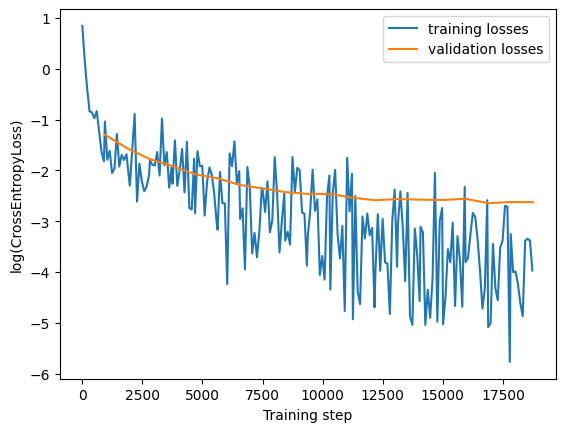

In [ ]:
"""
Below code shoud be run after resetting the model and loss arrays, i.e.
re-running the 10th and 11th blocks above.
"""

# train for 10 epochs, timing each epoch and the time for all 10 epochs
start = time.time()

for epoch in range(0, 10):
  epoch_start = time.time()

  current_step = cpu_train(current_epoch, train_losses, train_steps, current_step)

  print("\nEpoch", epoch, "time (seconds):", time.time() - epoch_start, "\n")

  cpu_test(test_losses, test_accuracy, test_steps, current_step)
  current_epoch += 1

print("\nTime for 10 epochs with testing (seconds):", time.time() - start, "\n")

# train for 10 more epochs
for epoch in range(0, 10):
    current_step = cpu_train(current_epoch, train_losses, train_steps, current_step)
    cpu_test(test_losses, test_accuracy, test_steps, current_step)
    current_epoch += 1

# print the total execution time
print("\nTotal execution time (seconds):", time.time() - start, "\n")

# visualize the losses for 20 epochs
plt.plot(train_steps, np.log(train_losses), label="training losses")
plt.plot(test_steps, np.log(test_losses), label="validation losses")
plt.xlabel("Training step")
plt.ylabel("log(CrossEntropyLoss)")
plt.legend()

plt.show()

Make an observation from the above plot. Do the test and train loss curves indicate that the model should train longer to improve accuracy? Or does it indicate that 20 epochs is too long?

**Question 4**

20 epochs seems to be too long since the test loss flattens out as the training loss continues to drop, indicating overfitting to the training data.

## Moving to the GPU

Now that we have a model trained on the CPU, let's finally utilize the T4 GPU that we requested for this instance.

using a GPU with torch is relatively simple, but has a few gotchas. Torch abstracts away most of the CUDA runtime API, but has a few hold-over concepts such as moving data between devices.
Additionally, since the GPU is treated as a device seperate from the CPU, you cannot combine CPU and GPU based tensors in the same operation. Doing so will result in a device mismatch error. If this occurs, check where the tensors are located (you can always print `.device` on a tensor), and make sure they have been properly moved to the correct device.

We'll start by creating a new model, optimizer, and critereon (not necessary but for completeness). However, one change that we'll make is moving the model to the GPU first. This can be done by calling `.cuda()` in general, or `.to("cuda")` to be more explict. Specific GPU devices can be targetted such as `.to("cuda:0")` for the first GPU (index 0), but we only have 1 GPU in colab so this is not necessary.

In [ ]:
# create the model
model = MLP()

# move the model to the GPU
model.cuda()

# for a critereon (loss) funciton, we will use Cross-Entropy Loss. This is the most common critereon used for multi-class prediction, and is also used by tokenized transformer models
# it takes in an un-normalized probability distribution (i.e. without softmax) over N classes (in our case, 10 classes with MNIST). This distribution is then compared to an integer label
# which is < N. For MNIST, the prediction might be [-0.0056, -0.2044,  1.1726,  0.0859,  1.8443, -0.9627,  0.9785, -1.0752, 1.1376,  1.8220], with the label 3.
# Cross-entropy can be thought of as finding the difference between what the predicted distribution and the one-hot distribution

criterion = nn.CrossEntropyLoss()

# then we can intantiate the optimizer. We will use Stochastic Gradient Descent (SGD), and can set the learning rate to 0.1 with a momentum factor of 0.5
# the first input to the optimizer is the list of model parameters, which is obtained by calling .parameters() on the model object
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [ ]:
# create a new array to log the loss and accuracy
train_losses = []
train_steps = []
test_steps = []
test_losses = []
test_accuracy = []
current_step = 0  # Start with global step 0
current_epoch = 0 # Start with epoch 0

Now, copy your previous training code with the timing parameters below.
It needs to be slightly modified to move everything to the GPU.

Before the line `output = model(data)`, add:
```
data = data.cuda()
target = target.cuda()
```

Note that this is needed in both the train and test functions.

**Question 5**


In [ ]:
# the new GPU training functions
# declare the train function
def gpu_train(epoch, train_losses, steps, current_step):

    # set the model in training mode - this doesn't do anything for us right now, but it is good practiced and needed with other layers such as batch norm and dropout
    model.train()

    # Create tqdm progress bar to help keep track of the training progress
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))

    # loop over the dataset. Recall what comes out of the data loader, and then by wrapping that with enumerate() we get an index into the iterator list which we will call batch_idx
    for batch_idx, (data, target) in pbar:

        # during training, the first step is to zero all of the gradients through the optimizer
        # this resets the state so that we can begin back propogation with the updated parameters
        optimizer.zero_grad()

        # move data and labels to gpu
        data = data.cuda()
        target = target.cuda()

        # then we apply a forward pass, which includes evaluating the loss (critereon)
        output = model(data)
        loss = criterion(output, target)

        # given that we want to minimize the loss, we call .backward() on the result, which invokes the grad_fn property
        loss.backward()

        # the backward step will automatically differentiate the model and apply a gradient property to each of the parameters in the network
        # so then all we have to do is call optimizer.step() to apply the gradients to the current parameters
        optimizer.step()

        # increment the step count
        current_step += 1

        # we should add some output to the progress bar so that we know which epoch we are training, and what the current loss is
        if batch_idx % 100 == 0:

            # append the last loss value
            train_losses.append(loss.item())
            steps.append(current_step)

            desc = (f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                    f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            pbar.set_description(desc)

    return current_step

# declare a test function, this will help us evaluate the model progress on a dataset which is different from the training dataset
# doing so prevents cross-contamination and misleading results due to overfitting
def gpu_test(test_losses, test_accuracy, steps, current_step):

    # put the model into eval mode, this again does not currently do anything for us, but it is needed with other layers like batch_norm and dropout
    model.eval()
    test_loss = 0
    correct = 0

    # Create tqdm progress bar
    pbar = tqdm(test_loader, total=len(test_loader), desc="Testing...")

    # since we are not training the model, and do not need back-propogation, we can use a no_grad() context
    with torch.no_grad():
        # iterate over the test set
        for data, target in pbar:
            # move data and labels to gpu
            data = data.cuda()
            target = target.cuda()

            # like with training, run a forward pass through the model and evaluate the critereon
            output = model(data)
            test_loss += criterion(output, target).item() # we are using .item() to get the loss value rather than the tensor itself

            # we can also check the accuracy by sampling the output - we can use greedy sampling which is argmax (maximum probability)
            # in general, you would want to normalize the logits first (the un-normalized output of the model), which is done via .softmax()
            # however, argmax is taking the maximum value, which will be the same index for the normalized and un-normalized distributions
            # so we can skip a step and take argmax directly
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)

    # append the final test loss
    test_losses.append(test_loss)
    test_accuracy.append(correct/len(test_loader.dataset))
    steps.append(current_step)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}'
          f' ({100. * correct / len(test_loader.dataset):.0f}%)\n')


In [ ]:
# new GPU training for 10 epochs
start = time.time()

for epoch in range(0, 10):
    epoch_start = time.time()
    current_step = gpu_train(current_epoch, train_losses, train_steps, current_step)
    print("\nEpoch", epoch, "time (seconds):", time.time() - epoch_start, "\n")

    gpu_test(test_losses, test_accuracy, test_steps, current_step)

    current_epoch += 1

print("Total execution time (seconds):", time.time() - start)

Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.374869: 100%|██████████| 938/938 [00:14<00:00, 63.76it/s]



Epoch 0 time (seconds): 14.716701030731201 



Testing...: 100%|██████████| 157/157 [00:02<00:00, 67.89it/s]



Test set: Average loss: 0.2713, Accuracy: 9222/10000 (92%)



Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.260934: 100%|██████████| 938/938 [00:13<00:00, 70.85it/s]



Epoch 1 time (seconds): 13.242704629898071 



Testing...: 100%|██████████| 157/157 [00:02<00:00, 66.49it/s]



Test set: Average loss: 0.1990, Accuracy: 9406/10000 (94%)



Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.265895: 100%|██████████| 938/938 [00:13<00:00, 71.53it/s]



Epoch 2 time (seconds): 13.11566424369812 



Testing...: 100%|██████████| 157/157 [00:01<00:00, 82.43it/s]



Test set: Average loss: 0.1646, Accuracy: 9518/10000 (95%)



Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.194435: 100%|██████████| 938/938 [00:13<00:00, 71.87it/s]



Epoch 3 time (seconds): 13.054803609848022 



Testing...: 100%|██████████| 157/157 [00:02<00:00, 67.87it/s]



Test set: Average loss: 0.1379, Accuracy: 9579/10000 (96%)



Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.047960: 100%|██████████| 938/938 [00:13<00:00, 69.76it/s]



Epoch 4 time (seconds): 13.449045419692993 



Testing...: 100%|██████████| 157/157 [00:01<00:00, 82.40it/s]



Test set: Average loss: 0.1235, Accuracy: 9634/10000 (96%)



Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.034429: 100%|██████████| 938/938 [00:13<00:00, 71.20it/s]



Epoch 5 time (seconds): 13.175869941711426 



Testing...: 100%|██████████| 157/157 [00:01<00:00, 80.64it/s]



Test set: Average loss: 0.1148, Accuracy: 9650/10000 (96%)



Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.017611: 100%|██████████| 938/938 [00:12<00:00, 72.24it/s]



Epoch 6 time (seconds): 12.989181756973267 



Testing...: 100%|██████████| 157/157 [00:01<00:00, 81.27it/s]



Test set: Average loss: 0.1015, Accuracy: 9696/10000 (97%)



Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.238440: 100%|██████████| 938/938 [00:13<00:00, 71.61it/s]



Epoch 7 time (seconds): 13.102691173553467 



Testing...: 100%|██████████| 157/157 [00:02<00:00, 58.25it/s]



Test set: Average loss: 0.0991, Accuracy: 9688/10000 (97%)



Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.041483: 100%|██████████| 938/938 [00:13<00:00, 71.44it/s]



Epoch 8 time (seconds): 13.133606433868408 



Testing...: 100%|██████████| 157/157 [00:02<00:00, 77.36it/s]



Test set: Average loss: 0.0902, Accuracy: 9706/10000 (97%)



Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.105685: 100%|██████████| 938/938 [00:13<00:00, 70.78it/s]



Epoch 9 time (seconds): 13.257645606994629 



Testing...: 100%|██████████| 157/157 [00:01<00:00, 82.76it/s]


Test set: Average loss: 0.0889, Accuracy: 9723/10000 (97%)

Total execution time (seconds): 154.5678780078888


Is training faster now that it's on the GPU? Is the speedup what you would expect? Why or why not?

**Question 6**

Comparing this execution time with the execution time previously recorded for 10 epochs on the CPU, training takes about the same amount of time on the GPU as it did on the CPU. I expected the GPU's parallelism to speed up the process, however I could see it being the case that the model and input data are not large enough to fully take advantage of the GPU's parallelism.

## Another Model Type: CNN

We've trained a simple MLP for MNIST classification, however, MLPs are not a particularly good fit for images.

Firstly, using a MLP will require that all images have the same size and shape, since they are unrolled in the input.

Secondly, images can make use of translation invariance (a type of data symmetry), which cannot leveraged with a MLP.

For these reasons, a convolutional network may be more appropriate, as it will pass kernels over the 2D image, removing the requirement for a fixed image size and leveraging the translation invariance of the 2D images.

Let's define a simple CNN below.

In [ ]:
# Define the CNN model
class CNN(nn.Module):
    # define the constructor for the network
    def __init__(self):
        super().__init__()
        # instead of declaring the layers independently, let's use the nn.Sequential feature
        # these blocks will be executed in list order

        # we will break up the model into two parts:
        # 1) the convolutional network
        # 2) the prediction head (a small MLP)

        # the convolutional network
        self.net = nn.Sequential(
          nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # the input projection layer - note that a sride of 1 means we are not down-sampling
          nn.ReLU(),                                             # activation
          nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # an inner layer - note that a stride of 2 means we are down sampling. The output is 28x28 -> 14x14
          nn.ReLU(),                                             # activation
          nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),# an inner layer - note that a stride of 2 means we are down sampling. The output is 14x14 -> 7x7
          nn.ReLU(),                                             # activation
          nn.AdaptiveMaxPool2d(1),                               # a pooling layer which will output a 1x1 vector for the prediciton head
        )

        # the prediction head
        self.head = nn.Sequential(
          nn.Linear(128, 64),      # input projection, the output from the pool layer is a 128 element vector
          nn.ReLU(),               # activation
          nn.Linear(64, 10)        # class projection to one of the 10 classes (digits 0-9)
        )


    # define the forward pass compute graph
    def forward(self, x):

        # pass the input through the convolution network
        x = self.net(x)

        # reshape the output from Bx128x1x1 to Bx128
        x = x.view(x.size(0), -1)

        # pass the pooled vector into the prediction head
        x = self.head(x)

        # the output here is Bx10
        return x

In [ ]:
# create the model
model = CNN()

# print the model and the parameter count
print(model)
param_count = sum([p.numel() for p in model.parameters()])
print(f"Model has {param_count:,} trainable parameters")

# the loss function
criterion = nn.CrossEntropyLoss()

# then we can intantiate the optimizer. We will use Stochastic Gradient Descent (SGD), and can set the learning rate to 0.1 with a momentum factor of 0.5
# the first input to the optimizer is the list of model parameters, which is obtained by calling .parameters() on the model object
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

CNN(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): AdaptiveMaxPool2d(output_size=1)
  )
  (head): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)
Model has 101,578 trainable parameters


Notice that this model now has fewer parameters than the MLP. Let's see how it trains.

Using the previous code to train on the CPU with timing, execute 2 epochs of training.

**Question 7**

In [ ]:
# create a new array to log the loss and accuracy
train_losses = []
train_steps = []
test_steps = []
test_losses = []
test_accuracy = []
current_step = 0  # Start with global step 0
current_epoch = 0 # Start with epoch 0

In [ ]:
# train for 2 epochs on the CPU
start = time.time()

for epoch in range(0, 2):
  epoch_start = time.time()

  current_step = cpu_train(current_epoch, train_losses, train_steps, current_step)

  print("\nEpoch", epoch, "time (seconds):", time.time() - epoch_start, "\n")

  cpu_test(test_losses, test_accuracy, test_steps, current_step)
  current_epoch += 1

print("\nTotal execution time (seconds):", time.time() - start, "\n")


Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.674078: 100%|██████████| 938/938 [01:21<00:00, 11.44it/s]



Epoch 0 time (seconds): 81.97983860969543 



Testing...: 100%|██████████| 157/157 [00:05<00:00, 27.10it/s]



Test set: Average loss: 0.6868, Accuracy: 7648/10000 (76%)



Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.306157: 100%|██████████| 938/938 [01:23<00:00, 11.24it/s]



Epoch 1 time (seconds): 83.46533870697021 



Testing...: 100%|██████████| 157/157 [00:05<00:00, 29.74it/s]


Test set: Average loss: 0.2455, Accuracy: 9213/10000 (92%)


Total execution time (seconds): 176.52570056915283 



Now, let's move the model to the GPU and try training for 2 epochs there.

**Question 8**

In [ ]:
# create the model
model = CNN()

model.cuda()

# print the model and the parameter count
print(model)
param_count = sum([p.numel() for p in model.parameters()])
print(f"Model has {param_count:,} trainable parameters")

# the loss function
criterion = nn.CrossEntropyLoss()

# then we can intantiate the optimizer. We will use Stochastic Gradient Descent (SGD), and can set the learning rate to 0.1 with a momentum factor of 0.5
# the first input to the optimizer is the list of model parameters, which is obtained by calling .parameters() on the model object
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

CNN(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): AdaptiveMaxPool2d(output_size=1)
  )
  (head): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)
Model has 101,578 trainable parameters


In [ ]:
# create a new array to log the loss and accuracy
train_losses = []
train_steps = []
test_steps = []
test_losses = []
test_accuracy = []
current_step = 0  # Start with global step 0
current_epoch = 0 # Start with epoch 0

In [ ]:
# train for 2 epochs on the GPU
start = time.time()

for epoch in range(0, 2):
    epoch_start = time.time()
    current_step = gpu_train(current_epoch, train_losses, train_steps, current_step)
    print("\nEpoch", epoch, "time (seconds):", time.time() - epoch_start, "\n")

    gpu_test(test_losses, test_accuracy, test_steps, current_step)

    current_epoch += 1

print("Total execution time (seconds):", time.time() - start)

Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.823945: 100%|██████████| 938/938 [00:15<00:00, 60.79it/s]



Epoch 0 time (seconds): 15.433212757110596 



Testing...: 100%|██████████| 157/157 [00:02<00:00, 59.06it/s]



Test set: Average loss: 0.7019, Accuracy: 7591/10000 (76%)



Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.170722: 100%|██████████| 938/938 [00:14<00:00, 66.52it/s]



Epoch 1 time (seconds): 14.106836557388306 



Testing...: 100%|██████████| 157/157 [00:02<00:00, 73.22it/s]


Test set: Average loss: 0.2921, Accuracy: 9051/10000 (91%)

Total execution time (seconds): 34.34917068481445


How do the CPU and GPU versions compare for the CNN? Is one faster than the other? Why do you think this is, and how does it differ from the MLP?

**Question 9**

For the CNN, the GPU execution time is much faster (more than 10x) than the CPU. I believe there is a speedup here because of the convolution operations in each convolutional layer, which each consist of many multiply-accumulate operations as the kernels "slide" across the input matrices. Even though the MLP from earlier contains more parameters, a forward pass in that MLP only consists of three matrix-vector multiplications (ome corresponding to each fully connected layer). Thus, even though the CNN has less parameters it performs many more floating-point operations than the MLP, and thus can take more advatnage of the GPU's parallelism.

As a final comparison, we can profile the FLOPs (floating-point operations) executed by each model. We will use the thop.profile function for this and consider an MNIST batch size of 1.

In [ ]:
# the input shape of a MNIST sample with batch_size = 1
input = torch.randn(1, 1, 28, 28)

# create a copy of the models on the CPU
mlp_model = MLP()
cnn_model = CNN()

# profile the MLP
flops, params = thop.profile(mlp_model, inputs=(input, ), verbose=False)
print(f"MLP has {params:,} params and uses {flops:,} FLOPs")

# profile the CNN
flops, params = thop.profile(cnn_model, inputs=(input, ), verbose=False)
print(f"CNN has {params:,} params and uses {flops:,} FLOPs")

MLP has 109,386.0 params and uses 109,184.0 FLOPs
CNN has 101,578.0 params and uses 7,459,968.0 FLOPs


Are these results what you would have expected? Do they explain the performance difference between running on the CPU and GPU? Why or why not?

**Question 10**

These results are what I expected based on the differences in GPU speed-up between the two models. The MLP had no speed-up when running on the GPU because it simply did not perform enough FLOPs for the GPU's throughput-oriented parallel design to outperform the CPU's latency-oriented sequential design. On the other hand, the CNN performs more than 10 times more FLOPs than the MLP, and thus is able to take advantage of the GPU's parallelism and see a significant speed-up when executing on the GPU.